# Neural style transfer (transferencia de estilo neuronal)

Fuente: https://colab.research.google.com/drive/1H-lNMxVF9NPME6oZVphFRoi7yglJMZxP


## Introducción

Transferencia de estilo consiste en generar una imagen con el mismo "contenido" que una imagen base dada, pero con un "estilo" de otra imagen.

Esto se hace optimizando una función de costo que tiene 3 componentes:

1. style loss
2. content loss
3. total variation loss

- 3. impone una continuidad espacial local entre los píxeles de la imágen combinada, dándole coherencia visual
- 1. es lo que define el estilo, es una suma de distancias L2 entre las matrices GRam de las representaciones de la imagen base y la imagen de estilo, extraídas en las diferentes capas de una ConvNet (entrenada con ImageNet). La idea es capturar la información de color/textura en diferentes escalas temporales
- 2. es la distancia L2 entre las features de la imagen base (extraídas de una capa profunda de la red) y las features de la imagen generada, esto hace que la imagen generada sea parecida a la imagen base

**Referencia:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)


## Setup


In [ ]:
# usar GPU en colab
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
)

result_prefix = "paris_generated"

base_image_path = keras.utils.get_file("budapest.jpg", "https://www.spotgrapher.com/wp-content/uploads/2019/12/budapest-danubio-parlamento-1552491234-1024x683.jpg")
style_reference_image_path = keras.utils.get_file(
    "jury_of_eight.jpg", "https://render.fineartamerica.com/images/images-profile-flow/400/images-medium-large-5/--jury-of-eight--michael-lang.jpg"
)

result_prefix = "budapest_generated"

# pesos de los diferentes componentes de la función de costo
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# dimensiones de la imagen generada
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


Found GPU at: /device:GPU:0
73728/72272 [==============================] - 0s 0us/step


## Veamos la imagen base e imagen de estilo

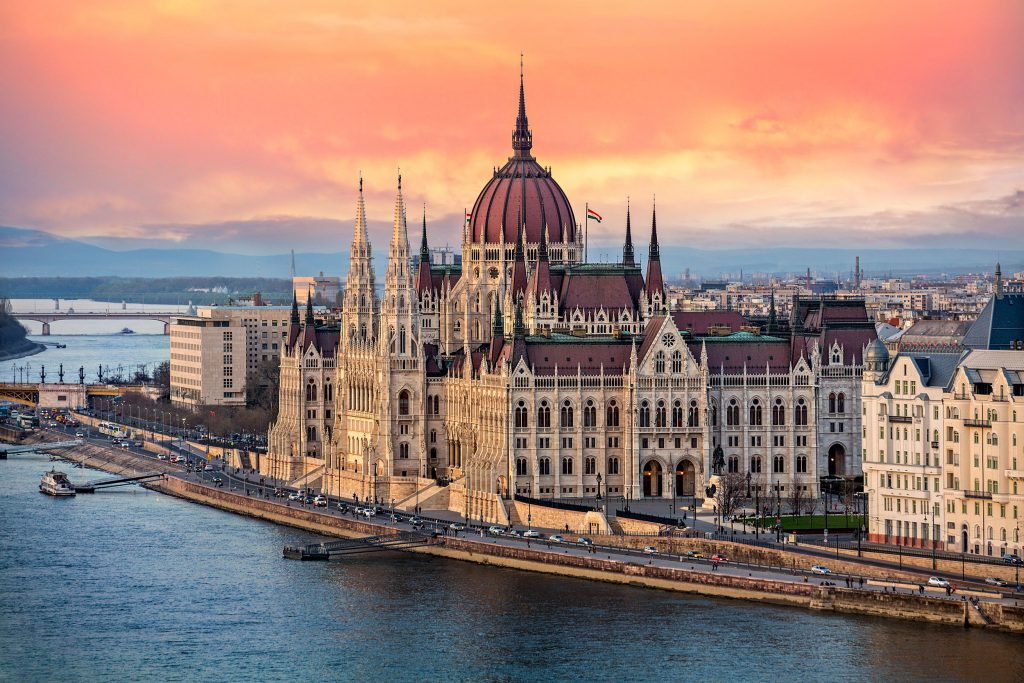

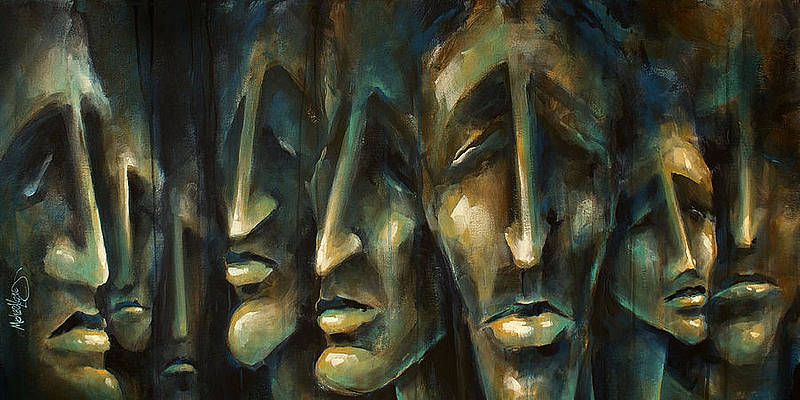

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))


## Image preprocessing / deprocessing utilities


In [ ]:

def preprocess_image(image_path):
    # función paa abrir, redimensionar y darle el formato correcto de tensores a las imágenes
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # imágen que convierte un tensor en una imágen
    x = x.reshape((img_nrows, img_ncols, 3))
    # revertir la substracción de media
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Computar la función de costo de estilo

Primero, definimos 4 funciones de utilidad:

- `gram_matrix` usada para computar la función de costo de estilo
- La función `style_loss`, que mantiene la imagen generada con el mismo estilo de la de referencia de estilo

- La función `content_loss`, que mantiene una representación de alto nivel de la imagen generada cercana a la de la imagen base

- La función `total_variation_loss`, un costo regularizador uqe mantiene la imagen generada localmente coherente


In [ ]:

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))




Ahora obtenemos un modelo del cual obtener las activaciones intermedias. Usamos VGG19

In [ ]:
# armar un modelo VGG19 cargado con los pesos pre-entrenados en ImageNet
model = vgg19.VGG19(weights="imagenet", include_top=False)

# obtener salidas simbólicas de cada capa "clave"
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# armar un modelo que retorna las activaciones para cada capa en VGG19
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Finally, here's the code that computes the style transfer loss.


In [ ]:
# lista de capas usadas en la función de costo de estilo
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# la capa usada para el costo de contenido
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # inicializar el costo
    loss = tf.zeros(shape=())

    # sumar el costo de contenido
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # sumar el costo de estilo
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # sumar el costo de variación total
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



## agregar un decorador tf.function al cómputo de costo y gradiente
Esto provoca que se compile y corra más rápido.


In [ ]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads



## Bucle de entrenamiento

Descendemos en la dirección del gradiente repetidamente para minimizar el costo y salvamos la imagen cada 100 iteraciones.

El learning rate se decae por 0.96 cada 100 iteraciones


In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

with tf.device('/device:GPU:0'):
  iterations = 3000
  for i in range(1, iterations + 1):
      loss, grads = compute_loss_and_grads(
          combination_image, base_image, style_reference_image
      )
      optimizer.apply_gradients([(grads, combination_image)])
      if i % 100 == 0:
          print("Iteration %d: loss=%.2f" % (i, loss))
          img = deprocess_image(combination_image.numpy())
          fname = result_prefix + "_at_iteration_%d.png" % i
          keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=3930.47
Iteration 200: loss=2632.75
Iteration 300: loss=2173.87
Iteration 400: loss=1940.90
Iteration 500: loss=1797.23
Iteration 600: loss=1698.41
Iteration 700: loss=1625.64
Iteration 800: loss=1569.43
Iteration 900: loss=1524.62
Iteration 1000: loss=1487.98
Iteration 1100: loss=1457.29
Iteration 1200: loss=1431.20
Iteration 1300: loss=1408.63
Iteration 1400: loss=1388.97
Iteration 1500: loss=1371.59
Iteration 1600: loss=1356.21
Iteration 1700: loss=1342.46
Iteration 1800: loss=1330.09
Iteration 1900: loss=1318.84
Iteration 2000: loss=1308.62
Iteration 2100: loss=1299.30
Iteration 2200: loss=1290.74
Iteration 2300: loss=1282.82
Iteration 2400: loss=1275.47
Iteration 2500: loss=1268.69
Iteration 2600: loss=1262.39
Iteration 2700: loss=1256.53
Iteration 2800: loss=1251.09
Iteration 2900: loss=1246.05
Iteration 3000: loss=1241.33


Después de 500 iteraciones obtenemos el siguiente resultado


In [ ]:
display(Image(result_prefix + "_at_iteration_100.png"))
display(Image(result_prefix + "_at_iteration_300.png"))
display(Image(result_prefix + "_at_iteration_500.png"))
display(Image(result_prefix + "_at_iteration_1000.png"))
display(Image(result_prefix + "_at_iteration_1500.png"))
display(Image(result_prefix + "_at_iteration_2000.png"))
display(Image(result_prefix + "_at_iteration_2500.png"))
display(Image(result_prefix + "_at_iteration_3000.png"))
